In [0]:
import os
import sys
sys.path.append("..")
sys.path.append("/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed")
sys.path.append("/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/data_loader")
sys.path.append("/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/models")

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import random
import matplotlib as plt
from sklearn.manifold import TSNE
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
from data_loader.Nottingham_database_preprocessor import *
from data_loader.Nottingham_database_preprocessor_util import *
from models.pitch_encoder_decoder import *

load_model_path = "/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/pitch_encoder_decoder"
store_model_path = "/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/pitch_encoder_decoder"

In [0]:
z_dim=10
hid_dim=80
one_hot_size=130
octave_out_dim=12
chroma_out_dim=14
n_epoch=500

In [5]:
pitches,octaves,chromas,pitches_one_hot,octaves_one_hot,chromas_one_hot = generate_pitchs_octaves_chromas()

[-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
[-3, -2, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9]
[-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 

In [0]:
pitch_VAE_package = build_pitch_encoder_decoder_model(z_dim,hid_dim,one_hot_size,octave_out_dim,chroma_out_dim, lr=1e-3)

In [0]:
pitch_VAE_package = train_pitch_encoder_decoder(pitch_VAE_package,pitches_one_hot,octaves_one_hot,chromas_one_hot,n_epoch,use_VAE=False)

In [7]:
pitch_VAE_package = load_pitch_VAE_models(pitch_VAE_package,load_model_path,n_epoch)

Load model from /content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/pitch_encoder_decoder/model_PitchEncoder_500.ckpt
Load model from /content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/pitch_encoder_decoder/model_PitchDecoder_500.ckpt
Load model from /content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/pitch_encoder_decoder/model_OctaveClassifier_500.ckpt
Load model from /content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/pitch_encoder_decoder/model_ChromaClassifier_500.ckpt


In [0]:
model_PitchEncoder = pitch_VAE_package['model_PitchEncoder']
model_PitchDecoder = pitch_VAE_package['model_PitchDecoder']
model_OctaveClassifier = pitch_VAE_package['model_OctaveClassifier']
model_ChromaClassifier = pitch_VAE_package['model_ChromaClassifier']

In [0]:
def pitch_sampler(pitch_z,model_PitchEncoder,model_PitchDecoder):
    decoded_pitch_vec,decoded_pitch = translate_z(pitch_z,model_PitchDecoder)
    pitch_num = decoded_pitch.tolist()
    if type(pitch_num)==list:
        pitch_1_hot=[pitch2onehot(pitch_num[i]) for i in len(pitch_num)]
    else:
        pitch_1_hot = [pitch2onehot(pitch_num)]
    z_resample,_,_ = encode_pitch(pitch_1_hot,model_PitchEncoder)
    print(pitch_1_hot)
    print(z_resample)
    return z_resample,pitch_num,pitch_1_hot

In [10]:
sample_id=int(random.random()*130)

z, mu, log_var = encode_pitch(pitches_one_hot[sample_id],model_PitchEncoder)
decoded_pitch_vec,decoded_pitch = translate_z(z,model_PitchDecoder)
decoded_octave_vec,decoded_octave = translate_z(z,model_OctaveClassifier)
decoded_chroma_vec,decoded_chroma = translate_z(z,model_ChromaClassifier)

print('original pitch is %d, decoded pitch is %d'%(pitches[sample_id],int(decoded_pitch)))
print('original octave is %d, decoded octave is %d'%(octaves[sample_id],int(decoded_octave)))
print('original chroma is %d, decoded pitch is %d'%(chromas[sample_id],int(decoded_chroma)))
var = torch.exp(log_var)
noise = torch.randn([10]).to(device)*var*50

print('var = ',var)
print('noise = ',noise)

dim_to_change=3
z_init = z
for i in range(50):
    print('------------------%d----------------'%i)
    z = z_init+noise*i
    z_resample,_,_ = pitch_sampler(z,model_PitchEncoder,model_PitchDecoder)
    decoded_pitch_vec,decoded_pitch = translate_z(z, model_PitchDecoder)
    decoded_octave_vec,decoded_octave = translate_z(z, model_OctaveClassifier)
    decoded_chroma_vec,decoded_chroma = translate_z(z, model_ChromaClassifier)
    print('distrubed pitch decoded = %d'%int(decoded_pitch))
    print('distrubed octave decoded = %d, correct decode = %d'%(int(decoded_octave),pitch2octave(int(decoded_pitch))))
    print('distrubed chroma decoded = %d, correct decode = %d'%(int(decoded_chroma),pitch2pitchclass(int(decoded_pitch))))
    decoded_pitch_vec,decoded_pitch = translate_z(z_resample, model_PitchDecoder)
    decoded_octave_vec,decoded_octave = translate_z(z_resample, model_OctaveClassifier)
    decoded_chroma_vec,decoded_chroma = translate_z(z_resample, model_ChromaClassifier)
    print('z_resample pitch decoded = %d'%int(decoded_pitch))
    print('z_resample octave decoded = %d, correct decode = %d'%(int(decoded_octave),pitch2octave(int(decoded_pitch))))
    print('z_resample chroma decoded = %d, correct decode = %d'%(int(decoded_chroma),pitch2pitchclass(int(decoded_pitch))))

/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/models/pitch_encoder_decoder.py:79: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_reconst = self.softmax(self.fc2(h))
/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/models/pitch_encoder_decoder.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(self.fc1(z))
/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/models/pitch_encoder_decoder.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(self.fc1(z))


original pitch is 73, decoded pitch is 73
original octave is 5, decoded octave is 5
original chroma is 1, decoded pitch is 1
var =  tensor([0.0047, 0.0022, 0.0026, 0.0013, 0.0011, 0.0031, 0.0030, 0.0018, 0.0045,
        0.0021], device='cuda:0', grad_fn=<ExpBackward>)
noise =  tensor([-0.0926, -0.2817,  0.0479, -0.0208,  0.0973, -0.2585, -0.3470, -0.1538,
        -0.1115, -0.1373], device='cuda:0', grad_fn=<MulBackward0>)
------------------0----------------
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
tensor([[ 0.2010,  3.1442,  2.1659, -0.1607, -1.3028,  0.3699, -2.0107, -0.6964,
          2.7783,  3.4077]], device='cuda:0', grad_fn=<AddBackwa

In [11]:
pitch_dataset = PitchDataset(pitches_one_hot,octaves_one_hot,chromas_one_hot)
pitch_dataloader = DataLoader(pitch_dataset, batch_size=1, shuffle=True)

pitch_reconst_list = []
octave_reconst_list = []
chroma_reconst_list = []
latent_pitch_list = []

for i,(this_pitch,this_octave,this_chroma) in enumerate(pitch_dataset):
    this_pitch = torch.LongTensor(this_pitch).float().to(device)
    this_octave = torch.LongTensor(this_octave).float().to(device)
    this_chroma = torch.LongTensor(this_chroma).float().to(device)
    z, mu, log_var = encode_pitch(this_pitch,model_PitchEncoder)
    x_reconst,decoded_pitch = translate_z(z, model_PitchDecoder)
    octave_pred,decoded_octave = translate_z(z, model_OctaveClassifier)
    chroma_pred,decoded_chroma = translate_z(z, model_ChromaClassifier)

    latent_pitch_list.append(mu.tolist())
    pitch_reconst_list.append(x_reconst.tolist())
    octave_reconst_list.append(octave_pred.tolist())
    chroma_reconst_list.append(chroma_pred.tolist())

/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/models/pitch_encoder_decoder.py:79: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_reconst = self.softmax(self.fc2(h))
/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/models/pitch_encoder_decoder.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(self.fc1(z))
/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/models/pitch_encoder_decoder.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(self.fc1(z))


In [0]:
import matplotlib as plt
from sklearn.manifold import TSNE
import numpy as np
from matplotlib.font_manager import *  
import matplotlib.pyplot as plt 

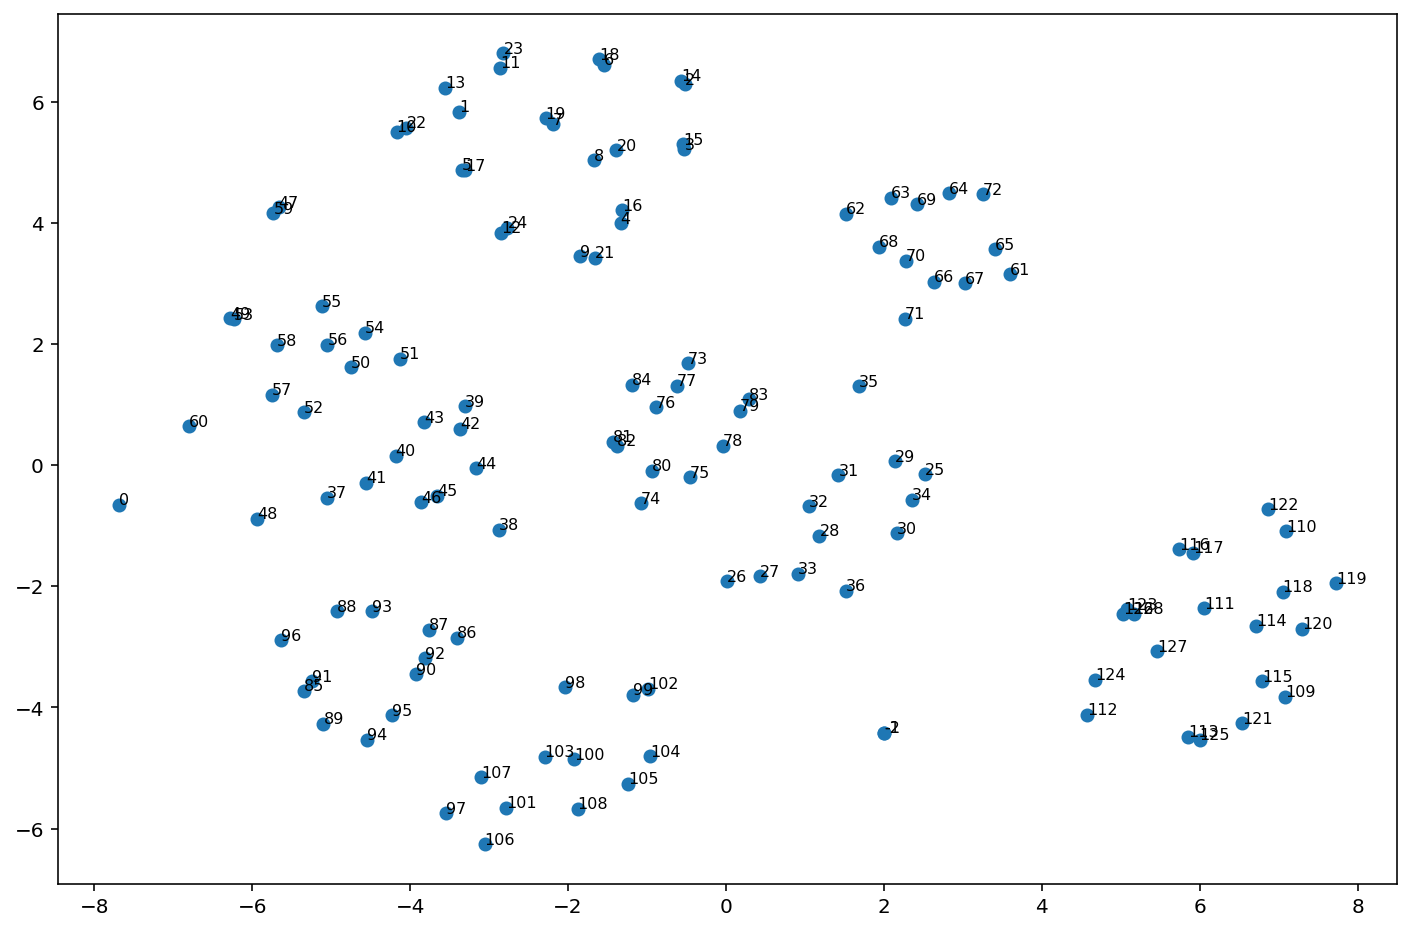

In [13]:
X_tsne = TSNE(n_components=2,learning_rate=100).fit_transform(np.array(latent_pitch_list))
fig = plt.figure(figsize=(12, 8)) 
ax = fig.gca()

ax.scatter(X_tsne[:,0],X_tsne[:,1])
for i in range(len(X_tsne)):
    x=X_tsne[i][0]
    y=X_tsne[i][1]
    ax.text(x , y , i-2,size = 8)

plt.show()